# Analysis of Citibike bike dock stations

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx
import plotly.express as px
import kaleido
import dash
from dash import html
import pydeck as pdk
import dash_deck

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data
* trips
* stations
* rebalance_pairs
    * transformed station pairs (further in notebook below)
* shapefiles and map tiles

In [ ]:
DATA_DIR = "../data/"
STATIONS_DIR = DATA_DIR + "stations/"
REBALANCE_DIR = DATA_DIR + "rebalance_parquet/"
GEN_DIR = "../gen/"

CRS_WEB_MERCATOR = 3857
CRS_OPENSTREETMAP = "WGS-84"

TRIP_YEAR = 2019

In [ ]:
# set mapbox token
MAPBOX_ACCESS_TOKEN = "MAPBOX_ACCESS_TOKEN"
os.environ[MAPBOX_ACCESS_TOKEN] = open("../.mapbox_token").read()

In [ ]:
%%time
trips = helpers.get_trips(TRIP_YEAR, DATA_DIR, convert_dates=True)

CPU times: user 54 s, sys: 48.4 s, total: 1min 42s
Wall time: 1min 25s


In [ ]:
# get top N stations by start of trips
stations_by_tripcount = (
    trips.groupby("startstationid")["bikeid"]
    .count()
    .reset_index()
    .rename(columns={"bikeid": "counttrips"})
    .sort_values(by="counttrips", ascending=False)
)

In [ ]:
# subway lines
subway_lines = gpd.read_file(DATA_DIR + "subwaylines" + helpers.GEOJSON_EXTENSION)
subway_lines = subway_lines.to_crs(CRS_WEB_MERCATOR)

In [ ]:
# read stations
stations = pd.read_csv(STATIONS_DIR + "stations.csv", index_col=0)
stations["stationid"] = stations["stationid"].astype("int64")

In [ ]:
# read boros
# See: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
# How convenient, they use NYC boroughs!
boros = gpd.read_file(gpd.datasets.get_path("nybb"))
# add coordinates for boro label. See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
boros = boros.to_crs(epsg=CRS_WEB_MERCATOR)
boros["boro_coords"] = boros["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
boros["boro_coords"] = [coords[0] for coords in boros["boro_coords"]]
bronx_staten_indices = [0, 4]  # not in our analysis scope

In [ ]:
# read rebalance pairs, use TRIP_YEAR alone
rebpairs = pd.read_parquet(
    REBALANCE_DIR + "rebalance_pairs" + helpers.PARQUET_EXTENSION, engine="pyarrow"
)
rebpairs = rebpairs.loc[rebpairs.rebal_year == TRIP_YEAR].drop("rebal_year", axis=1)
rebpairs["stationid_from"] = rebpairs["stationid_from"].astype("int")
rebpairs["stationid_to"] = rebpairs["stationid_to"].astype("int")

In [ ]:
# get sorted list of stations by number of bikes rebalanced (rebalanced from and rebalanced to)
stations_by_rebalcount = rebpairs.sort_values(by="rebal_count", ascending=False)
stations_by_rebalcount_from = list(
    stations_by_rebalcount.stationid_from.drop_duplicates()
)
stations_by_rebalcount_to = list(stations_by_rebalcount.stationid_to.drop_duplicates())

In [ ]:
# get total rebalances (from/to) for a stationid
total_rebal_from = (
    stations_by_rebalcount.groupby("stationid_from")["rebal_count"]
    .sum()
    .reset_index()
    .rename(columns={"rebal_count": "total_rebal_count_from"})
    .sort_values(by="total_rebal_count_from", ascending=False)
)
total_rebal_to = (
    stations_by_rebalcount.groupby("stationid_to")["rebal_count"]
    .sum()
    .reset_index()
    .rename(columns={"rebal_count": "total_rebal_count_to"})
    .sort_values(by="total_rebal_count_to", ascending=False)
)
stations_rebal = (
    pd.merge(
        left=total_rebal_from,
        right=total_rebal_to,
        left_on="stationid_from",
        right_on="stationid_to",
        how="outer",
        validate="1:1",
    )
    .drop("stationid_to", axis=1)
    .rename(columns={"stationid_from": "stationid"})
)

## Stations EDA

In [ ]:
def annotate_boros(row):
    """
    Annotate boro names See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
    :param row: the boro row
    :return: None
    """
    plt.annotate(
        text=row["BoroName"],
        xy=row["boro_coords"],
        horizontalalignment="left",
        color="Black",
        size=18,
        bbox={
            "boxstyle": "round",
            "facecolor": "white",
            "alpha": 0.8,
            "pad": 0.1,
            "edgecolor": "none",
        },
    )

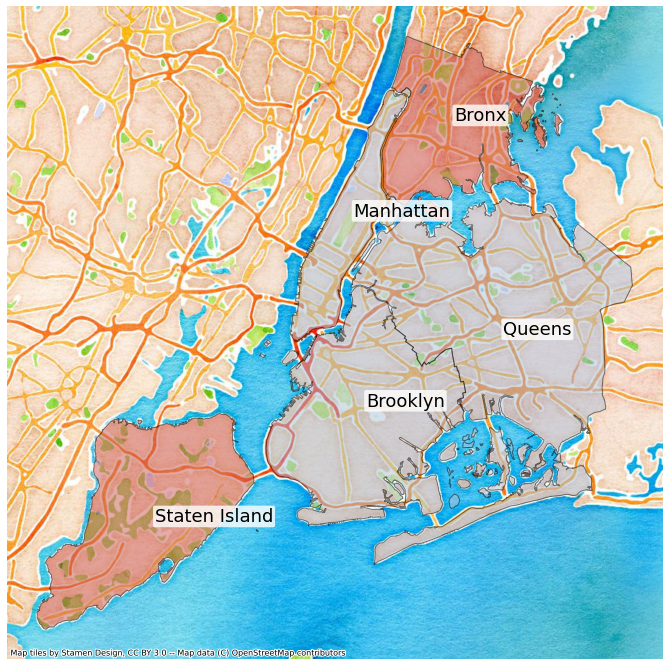

In [ ]:
# plot all 5 boros
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for idx, row in boros.iterrows():
    bronx_staten_indices = [0, 4]  # not in our analysis scope
    boro_color = "indianred" if idx in bronx_staten_indices else "lightsteelblue"
    ax = boros[boros.index == idx].plot(
        alpha=0.5, color=boro_color, edgecolor="k", ax=ax
    )
    annotate_boros(row)
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")

plt.show()

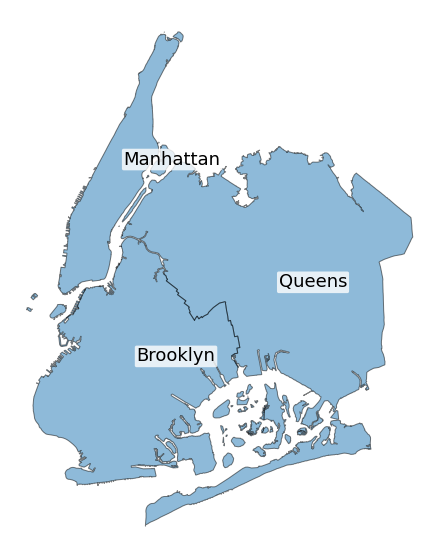

In [ ]:
# drop Staten Island and the Bronx by index
# plot boro shapefiles alone
boros.drop(index=[0, 4], inplace=True)
ax = boros.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros(row)
ax.axis("off")
plt.show()

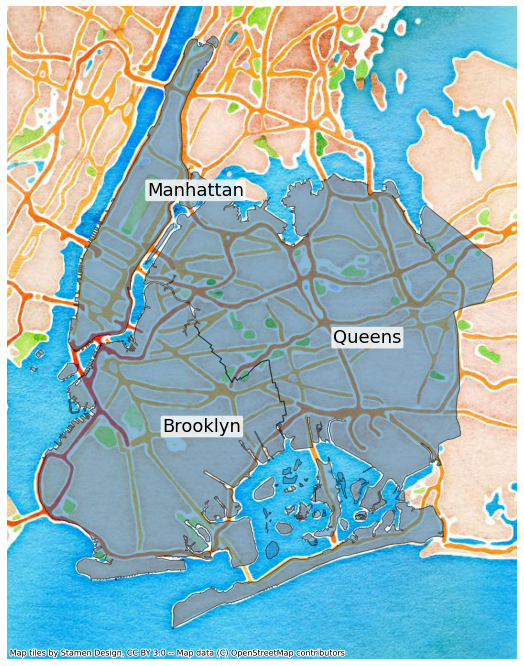

In [ ]:
# plot three boros in our dataset
ax = boros.plot(figsize=(12, 12), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros(row)
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")
plt.show()

In [ ]:
# drop stations with no latitude or longitude, those in 8D and the Bronx
stations = stations.drop(stations[stations["latitude"] == 0.0].index)
stations = stations.drop(stations[stations["longitude"] == 0.0].index)
stations = stations.drop(stations[stations["boro"] == "Ville-Marie"].index)
stations = stations.drop(stations[stations["boro"] == "The Bronx"].index)

In [ ]:
# merge to get tripcount. NOTE: this drops stations not in TRIP_YEAR
stations = pd.merge(
    left=stations_by_tripcount,
    right=stations,
    how="inner",
    left_on="startstationid",
    right_on="stationid",
).drop("startstationid", axis=1)
stations.insert(0, "stationid", stations.pop("stationid"))

In [ ]:
# add rebalance count (from/to) to stations
stations = pd.merge(left=stations, right=stations_rebal, how="left")

In [ ]:
# create geopandas dataframe and set CRS
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude)
)
stations_gdf.crs = CRS_OPENSTREETMAP
stations_gdf = stations_gdf.to_crs(epsg=CRS_WEB_MERCATOR)

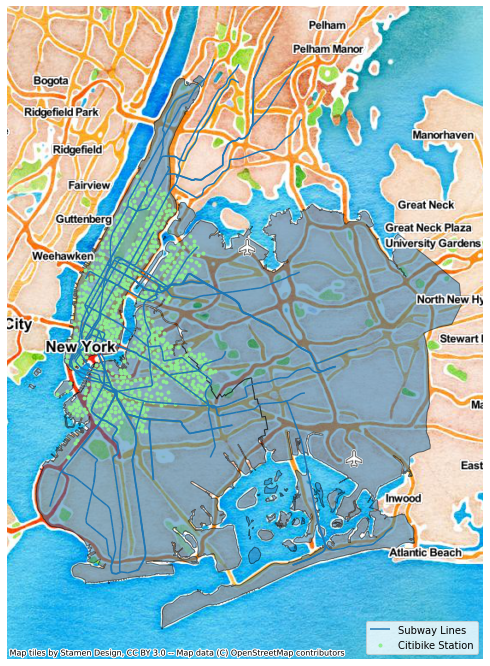

In [ ]:
# plot all stations
# TODO add subway lines https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax = boros.plot(alpha=0.5, edgecolor="k", ax=ax)
ax = subway_lines.plot(ax=ax, label="Subway Lines")
ax = stations_gdf.plot(color="lightgreen", ax=ax, label="Citibike Station", marker=".")
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.legend(loc="lower right")
ax.axis("off")

plt.show()

### Plot top stations by trip count, rebalances from, and rebalances to


In [ ]:
def plot_top_stations(
    N=100,
    column_by="counttrips",
    suptitle="SUPTITLE",
    title="SOMETHING",
    legend_label="Number of trips started at station",
    focus_manhattan=False,
    show_subway_lines=True,
):
    """
    Plots the top N stations by column
    :param N:
    :param column_by: one of {"counttrips", "total_rebal_count_from", "total_rebal_count_to"}
    :param title: figure title
    :param legend_label: legend label
    :param focus_manhattan: only draw the boro outline for Manhattan
    :return:
    """
    # plot top stations by tripcount (hint: they're all in Manhattan!)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    # Suptitle too high. See: https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # plot boros
    boro_colors = ["blue", "steelblue", "royalblue"]
    for idx, row in boros.iterrows():
        if focus_manhattan:
            if idx == 3:
                ax = boros[boros.index == idx].plot(
                    alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
                )
        else:
            ax = boros[boros.index == idx].plot(
                alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
            )
        annotate_boros(row)

    # plot subway lines
    if show_subway_lines:
        ax = subway_lines.plot(ax=ax, label="Subway Lines")

    # get the top N stations
    stations_gdf_topN = stations_gdf.sort_values(by=column_by, ascending=False).head(N)
    ax = stations_gdf_topN.plot(
        column="counttrips",
        cmap="YlOrRd",
        ax=ax,
        label="Citibike station",
        legend=True,
        legend_kwds={
            "label": legend_label,
            "orientation": "horizontal",
            "pad": 0.01,
            "shrink": 0.5,
            "alpha": 0.5,
        },
    )
    plt.suptitle(suptitle.format(N), fontsize=18)
    plt.title(title)

    cx.add_basemap(ax, source=cx.providers.Stamen.Toner)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
    ax.legend(loc="lower right")
    ax.axis("off")

    plt.show()

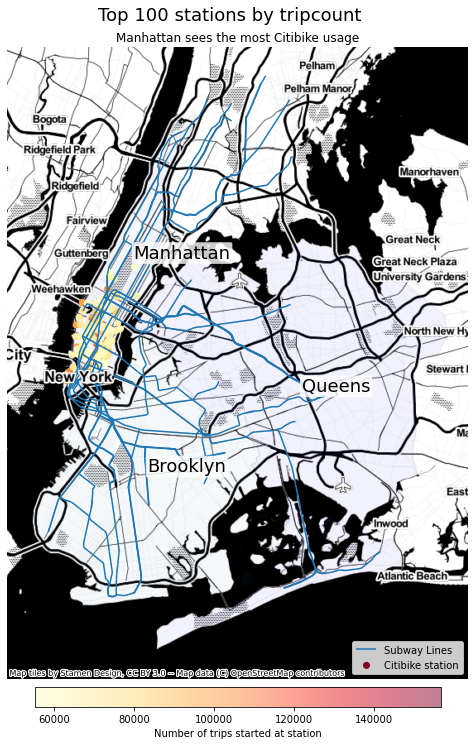

In [ ]:
plot_top_stations(
    N=100,
    column_by="counttrips",
    suptitle="Top {} stations by tripcount",
    title="Manhattan sees the most Citibike usage",
    legend_label="Number of trips started at station",
    focus_manhattan=False,
)

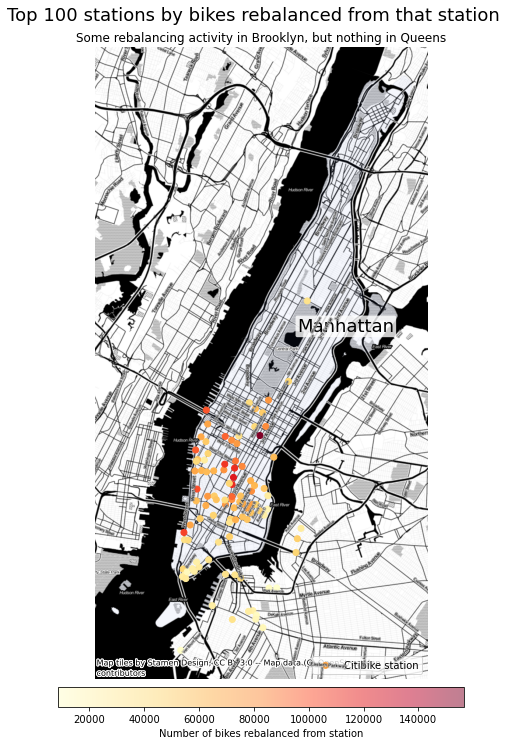

In [ ]:
plot_top_stations(
    N=100,
    column_by="total_rebal_count_from",
    suptitle="Top {} stations by bikes rebalanced from that station",
    title="Some rebalancing activity in Brooklyn, but nothing in Queens",
    legend_label="Number of bikes rebalanced from station",
    focus_manhattan=True,
    show_subway_lines=False,
)

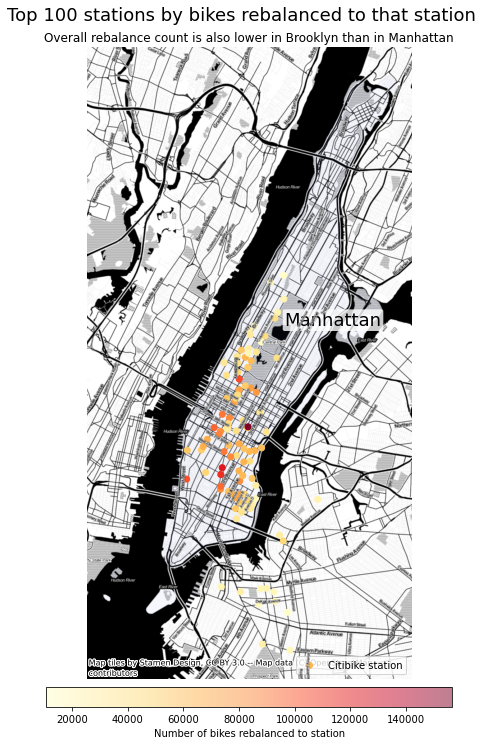

In [ ]:
plot_top_stations(
    N=100,
    column_by="total_rebal_count_to",
    suptitle="Top {} stations by bikes rebalanced to that station",
    title="Overall rebalance count is also lower in Brooklyn than in Manhattan",
    legend_label="Number of bikes rebalanced to station",
    focus_manhattan=True,
    show_subway_lines=False,
)

# Interactive Stations Plot

In [ ]:
fig = px.scatter_mapbox(
    stations_gdf,
    lat="latitude",
    lon="longitude",
    hover_name="stationname",
    hover_data={
        "counttrips": True,
        "total_rebal_count_from": True,
        "total_rebal_count_to": True,
        "latitude": False,
        "longitude": False,
    },
    size="counttrips",
    labels={
        "color": "Total rebalances (from/to)",
        "counttrips": "Total Trips",
        "total_rebal_count_from": "Rebalances (from)",
        "total_rebal_count_to": "Rebalances (to)",
    },
    color=(stations_gdf.total_rebal_count_from + stations_gdf.total_rebal_count_to),
    # color_continuous_scale=px.colors.sequential.Viridis[::-1],
    title="Citibike Dock Stations (2019)",
    zoom=12,
    height=1200,
    width=1000,
)
fig.update_coloraxes(colorbar_orientation="h")
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(
    mapbox_style="stamen-toner", mapbox_accesstoken=os.getenv(MAPBOX_ACCESS_TOKEN)
)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_mapboxes(pitch=30)
fig.show()

In [ ]:
# save figure
if not os.path.exists(GEN_DIR):
    os.mkdir(GEN_DIR)

In [ ]:
fig.write_image(GEN_DIR + "allstations" + helpers.PNG_EXTENSION)
fig.write_html(GEN_DIR + "allstations" + helpers.HTML_EXTENSION)

In [ ]:
# run interactive figure above
import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([dcc.Graph(figure=fig)])

app.run_server(debug=True, use_reloader=False)

### Plot station pairs

In [ ]:
STATIONS_PAIRS_DIR = DATA_DIR + "stations-pairs/"

TOOLTIP_TEXT = {
    "html": "{rebal_count} bikes to be rebalanced <br/>from {stationname_from} to {stationname_to}"
}

In [ ]:
station_pairs = pd.read_csv(
    STATIONS_PAIRS_DIR + "pairs" + helpers.CSV_EXTENSION, index_col=0
)

In [ ]:
# use custom tile layer See: https://github.com/ajduberstein/pydeck_custom_layer
# pydeck does not (yet) have a wrapper for deck.gl's TileLayers
pdk.settings.custom_libraries = [
    {
        "libraryName": "MyTileLayerLibrary",
        "resourceUri": "https://cdn.jsdelivr.net/gh/agressin/pydeck_myTileLayer@master/dist/bundle.js",
    }
]

DATA_URL = "https://stamen-tiles.a.ssl.fastly.net/toner/{z}/{x}/{y}.png"
# DATA_URL = 'https://stamen-tiles.a.ssl.fastly.net/watercolor/{z}/{x}/{y}.png'

tile_layer = pdk.Layer("MyTileLayer", DATA_URL)

In [ ]:
# transformation for circle size below
stations_gdf["total_rebal_count_from_plus_to"] = (
    stations_gdf.total_rebal_count_from + stations_gdf.total_rebal_count_to
)
stations_gdf["log_rebal"] = np.log(stations_gdf.total_rebal_count_from_plus_to)

In [ ]:
# Specify a deck.gl ScatterplotLayer
scatterplot_layer = pdk.Layer(
    "ScatterplotLayer",
    stations_gdf,
    pickable=False,
    opacity=0.8,
    stroked=True,
    filled=True,
    radius_scale=6,
    radius_min_pixels=1,
    radius_max_pixels=10,
    line_width_min_pixels=1,
    get_position=["longitude", "latitude"],
    get_radius="log_rebal",
    get_fill_color=[255, 140, 0],
    get_line_color=[0, 0, 0],
)

In [ ]:
# transformation for arc width below
station_pairs["log_rebal_count"] = np.log(station_pairs.rebal_count) / 2

In [ ]:
# Specify a deck.gl ArcLayer
SOURCE_RGB = [0, 255, 0, 100]
TARGET_RGB = [240, 100, 0, 100]

arc_layer = pdk.Layer(
    "ArcLayer",
    data=station_pairs,
    get_width="log_rebal_count",
    get_source_position=["longitude_from", "latitude_from"],
    get_target_position=["longitude_to", "latitude_to"],
    get_tilt=10,
    get_source_color=SOURCE_RGB,
    get_target_color=TARGET_RGB,
    pickable=True,
    auto_highlight=True,
)

In [ ]:
# plot station pairs with top rebalance pairs
view_state = pdk.ViewState(
    latitude=station_pairs.latitude_to.mean(),
    longitude=station_pairs.longitude_to.mean(),
    zoom=12,
    bearing=0,
    pitch=30,
)
r = pdk.Deck(
    [tile_layer, scatterplot_layer, arc_layer],
    initial_view_state=view_state,
    tooltip=TOOLTIP_TEXT,
    # map_style="dark",
    # map_provider="carto",
    # api_keys=os.getenv(MAPBOX_ACCESS_TOKEN)
)
r.to_html(GEN_DIR + "toparcs" + helpers.HTML_EXTENSION)

### Dash app (of sorts)

In [ ]:
# See https://github.com/plotly/dash-deck/blob/master/demos/usage-bootstrap.py
def Col(*args, md=None, **kwargs):
    if md is None:
        class_name = f"col"
    else:
        class_name = f"col-12 col-md-{md}"

    return html.Div(*args, className=class_name, **kwargs)


def Row(*args, **kwargs):
    return html.Div(*args, className="row", **kwargs)


def Card(*args, **kwargs):
    return html.Div(*args, className="card", **kwargs)


def CardBody(*args, **kwargs):
    return html.Div(*args, className="card-body", **kwargs)


def CardHeader(*args, **kwargs):
    return html.Div(*args, className="card-header", **kwargs)


app = dash.Dash(__name__)

# app.layout = html.Div(
#     dash_deck.DeckGL(
#         r.to_json(), id="deck-gl", tooltip=TOOLTIP_TEXT, mapboxKey=token
#     )
# )

deck_container = html.Div(
    dash_deck.DeckGL(
        r.to_json(),
        id="deck-gl",
        tooltip=TOOLTIP_TEXT,
        mapboxKey=os.getenv(MAPBOX_ACCESS_TOKEN),
    ),
    style={"height": "400px", "width": "100%", "position": "relative"},
)

graph_component = dcc.Graph(figure=fig)

app.layout = html.Div(
    className="container",
    children=[
        html.Br(),
        Row(
            [
                Col(
                    Card(
                        [
                            CardHeader("Trop 100 Dock Station Rebalance Pairs"),
                            CardBody(deck_container),
                        ]
                    )
                ),
                Col(Card([CardHeader("All Dock Stations"), CardBody(graph_component)])),
            ]
        ),
        # html.Br(),
        # Row(
        #     [
        #         Col(Card(CardBody("Some content here"))),
        #         Col(Card(CardBody("Some more content here"))),
        #     ]
        # ),
    ],
)

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
